<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº4
#### Mathilde d'Hébrail





### Configuracion e inicio de la simulacion

In [66]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,10)
import matplotlib.pyplot as plt
import scipy.signal as sig
import warnings
warnings.filterwarnings('ignore')
import math
from math import *

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi
fig_font_size = 16
plt.rcParams.update({'font.size':fig_font_size})
 

# Datos generales de la simulación
fs = 1000 # frecuencia de muestreo (Hz)
N = 1000   # cantidad de muestras
 
# cantidad de veces más densa que se supone la grilla temporal para tiempo "continuo"
over_sampling = 4
N_os = N*over_sampling
 
# Datos del ADC
B = 4 # bits
Vf = 2 # Volts
q = Vf/(2**B) # Volts

# Datos del señal senoidal
vmax = 1 #amplitud maximal de la senoidal (volts)
dc = 0 #valor medio (volts)
ph = 0 #fase (radianes)
 
# datos del ruido
k10 = 10
k1 = 1
k01 = 1/10
pot_ruido10 = ((q**2)/12) * k10 # Watts (potencia de la señal 1 W)
pot_ruido1 = ((q**2)/12) * k1 # Watts (potencia de la señal 1 W)
pot_ruido01 = ((q**2)/12) * k01 # Watts (potencia de la señal 1 W)

 
ts = 1/fs # tiempo de muestreo
df = fs/N # resolución espectral
df_os = fs/N_os

### Creacion de un señal senoidal:

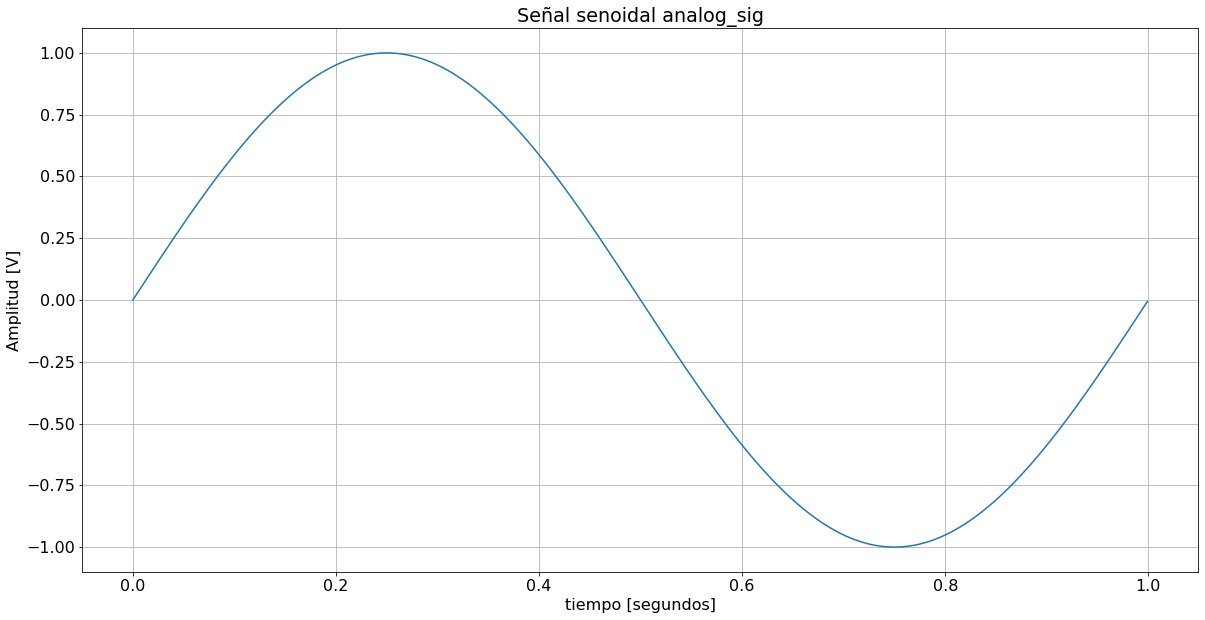

In [67]:
#Funcion para generar un señal senoidal
def mi_funcion_sen( vmax, dc, ff, ph, nn, fs ):
    
    ts = 1/fs # tiempo de muestreo
    df = fs/nn # resolución espectral
    
    # grilla de sampleo temporal
    tt = np.linspace(0, (N-1)*ts, N).flatten()
    
    # guardaremos las señales creadas al ir poblando la siguiente matriz vacía
    x = np.array([], dtype=np.float).reshape(N,0)
    
    aux = dc + vmax * np.sin( 2*np.pi*ff*tt + ph )
    xx = aux.reshape(N,1)
    
    return tt, xx.flatten()


#Creation del señal
tt_os, analog_sig = mi_funcion_sen( vmax, dc, df, ph, N_os, fs)  

# Presentación gráfica del señal
plt.figure(1)
line_hdls = plt.plot(tt_os, analog_sig)
plt.title('Señal senoidal analog_sig' )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
plt.grid(which='both', axis='both')
plt.show()

### Creation del señal ruidoso a partir del señal senoidal, y quantizacion sobre 4 bits

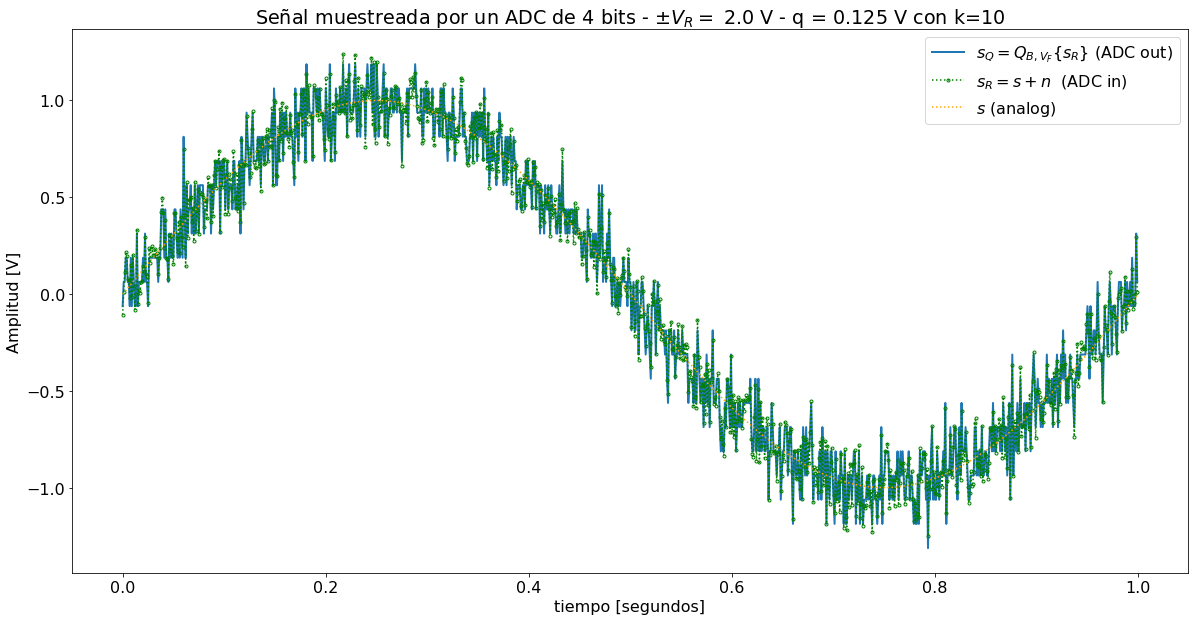

In [68]:
def agregar_ruido(xx, varianza):
    ruido = np.random.normal(0, np.sqrt(varianza), xx.shape)
    xx_ruidosa = xx + ruido
    return xx_ruidosa

sr10 = agregar_ruido(analog_sig, pot_ruido10)
sr1 = agregar_ruido(analog_sig, pot_ruido1)
sr01 = agregar_ruido(analog_sig, pot_ruido01)
ruido10 = sr10 - analog_sig
ruido1 = sr1 - analog_sig
ruido01 = sr01 - analog_sig



def quantizacion(xx, B, Vf):
    xx_quantizado =  np.round((xx-q/2)*(1/q))*q + q/2
    return xx_quantizado

sr10q = quantizacion(sr10, B, Vf)
sr1q = quantizacion(sr1, B, Vf)
sr01q = quantizacion(sr01, B, Vf)

nq10 = sr10q - sr10   # ruido de quantizacion
nq1 = sr1q - sr1   # ruido de quantizacion
nq01 = sr01q - sr01   # ruido de quantizacion


tt = np.linspace(0, (N-1)*ts, N).flatten()



#%% Presentación gráfica de los resultados
plt.close('all')
 
plt.figure(1)
plt.plot(tt, sr10q, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(tt, sr10, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V con k=10'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

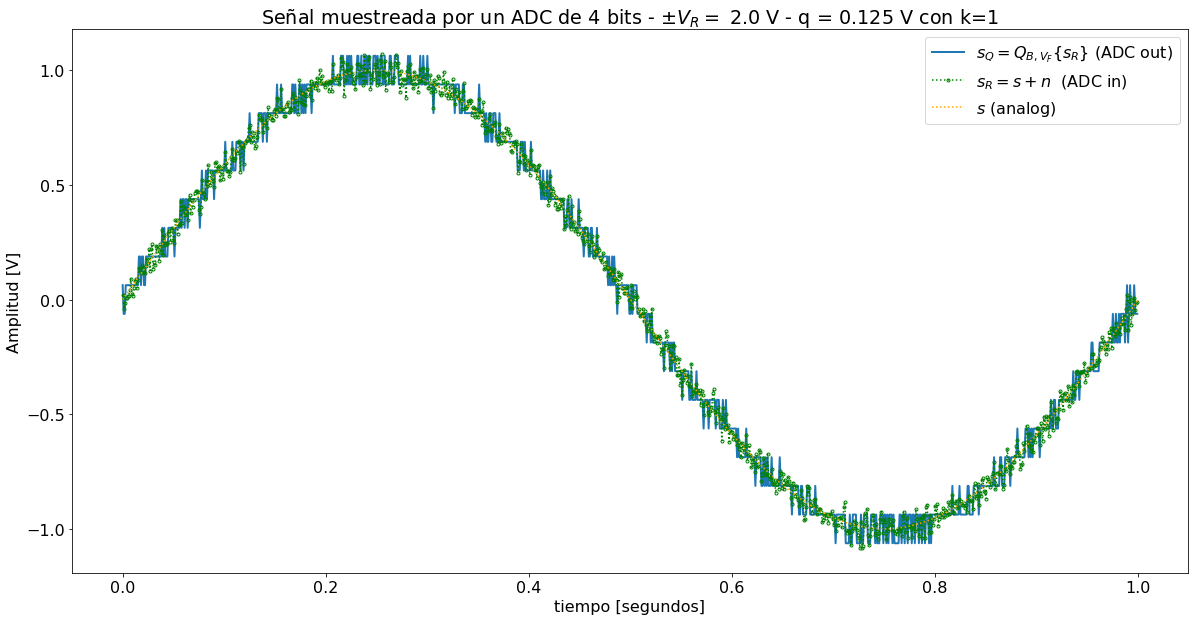

In [69]:
plt.figure(1)
plt.plot(tt, sr1q, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(tt, sr1, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V con k=1'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

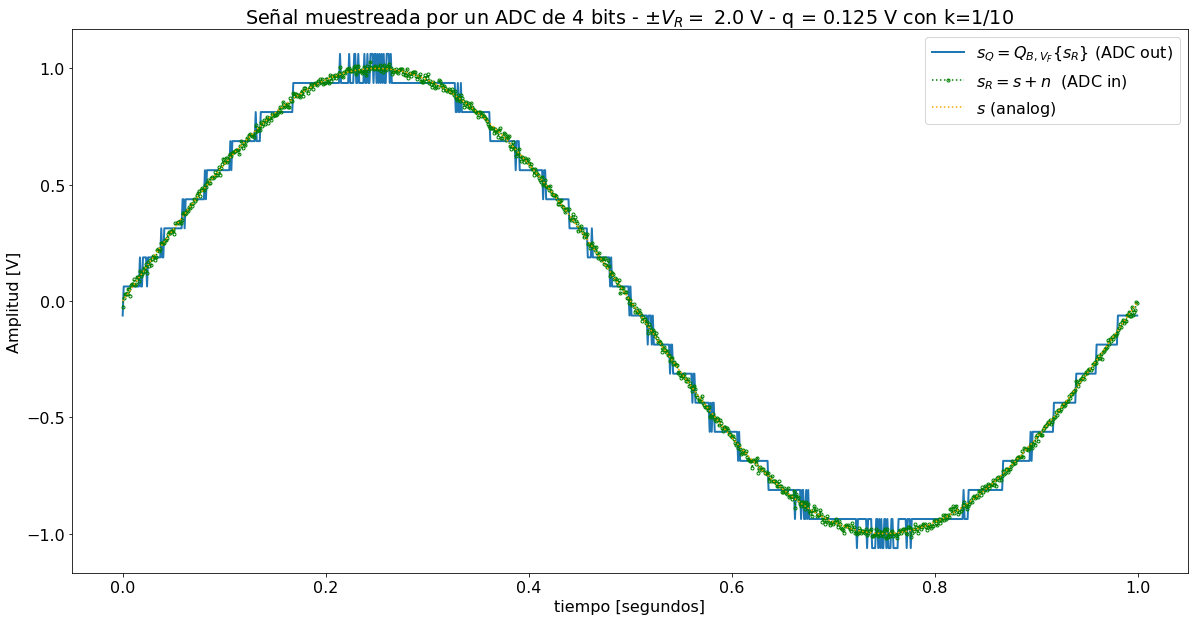

In [70]:
plt.figure(1)
plt.plot(tt, sr01q, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(tt, sr01, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V con k=1/10'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

(-39.407628760168414, 60.0)

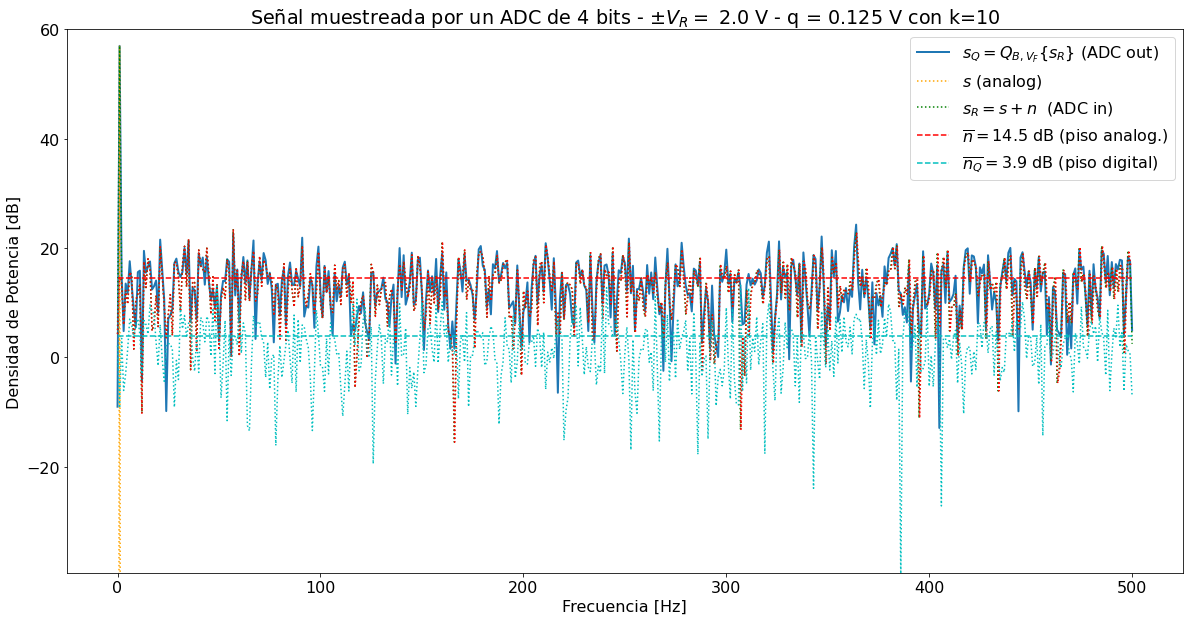

In [71]:
ft_As = np.fft.fft(analog_sig, axis = 0).flatten()
ft_SR10 = np.fft.fft(sr10, axis = 0).flatten()
ft_Sr10q = np.fft.fft(sr10q, axis = 0).flatten()
ft_Nn10 = np.fft.fft(ruido10, axis = 0).flatten()
ft_Nq10 = np.fft.fft(nq10, axis = 0).flatten()

ff = np.linspace(0, (N-1)*df, fs).flatten()
ff_os = np.linspace(0, (N_os-1)*df_os, fs).flatten()


# Oresentacion graphica de los resultados
plt.figure(2)
bfrec = ff <= fs/2  #select all the frequencies below fs/2
 
Nnq10_mean = np.mean(np.abs(ft_Nq10)**2)
nNn10_mean = np.mean(np.abs(ft_Nn10)**2)


plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Sr10q[bfrec])**2), lw = 2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR10[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn10[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq10[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn10_mean, nNn10_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn10_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq10_mean, Nnq10_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq10_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V con k=10'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((-10*np.min(10* np.log10(2* np.array([Nnq10_mean, nNn10_mean]))),60))

(-42.007943213656574, 60.0)

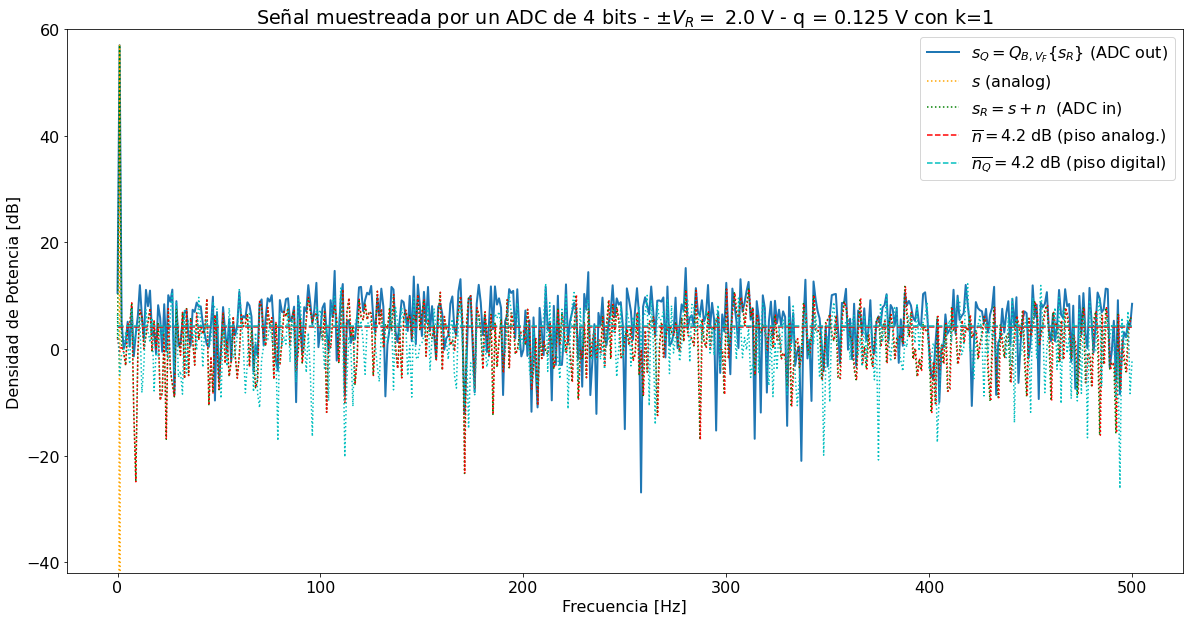

In [72]:
ft_As = np.fft.fft(analog_sig, axis = 0).flatten()
ft_SR1 = np.fft.fft(sr1, axis = 0).flatten()
ft_Sr1q = np.fft.fft(sr1q, axis = 0).flatten()
ft_Nn1 = np.fft.fft(ruido1, axis = 0).flatten()
ft_Nq1 = np.fft.fft(nq1, axis = 0).flatten()

ff = np.linspace(0, (N-1)*df, fs).flatten()
ff_os = np.linspace(0, (N_os-1)*df_os, fs).flatten()


# Oresentacion graphica de los resultados
plt.figure(2)
bfrec = ff <= fs/2  #select all the frequencies below fs/2
 
Nnq1_mean = np.mean(np.abs(ft_Nq1)**2)
nNn1_mean = np.mean(np.abs(ft_Nn1)**2)


plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Sr1q[bfrec])**2), lw = 2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR1[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn1[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq1[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn1_mean, nNn1_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn1_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq1_mean, Nnq1_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq1_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V con k=1'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((-10*np.min(10* np.log10(2* np.array([Nnq1_mean, nNn1_mean]))),60))

(-57.046410490522696, 60.0)

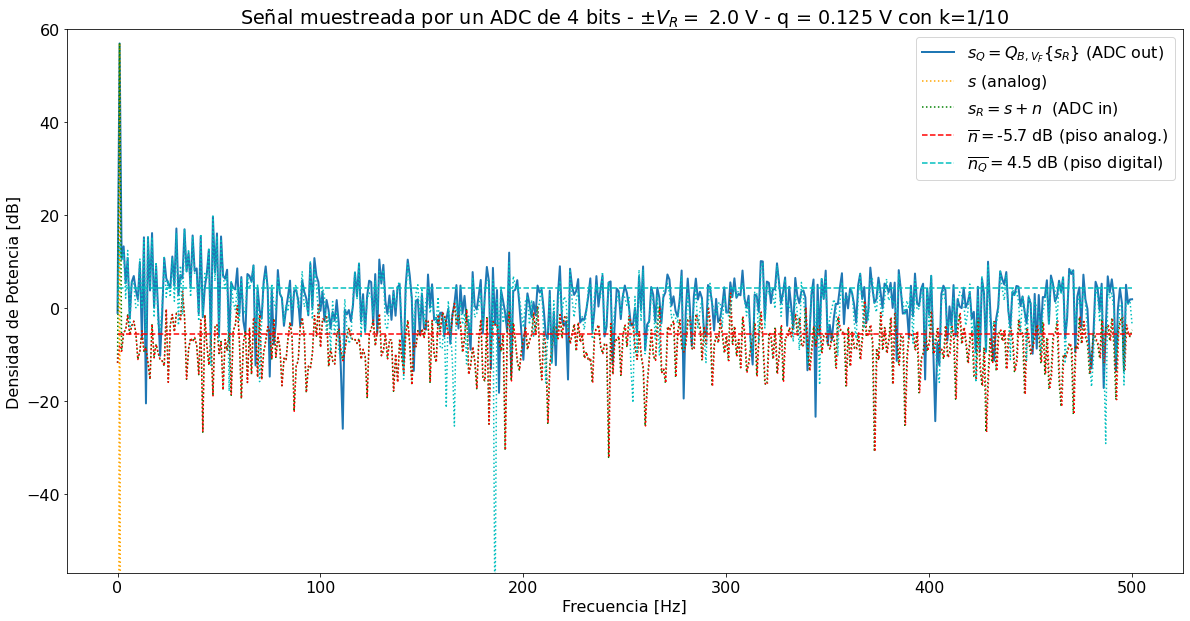

In [73]:
ft_As = np.fft.fft(analog_sig, axis = 0).flatten()
ft_SR01 = np.fft.fft(sr01, axis = 0).flatten()
ft_Sr01q = np.fft.fft(sr01q, axis = 0).flatten()
ft_Nn01 = np.fft.fft(ruido01, axis = 0).flatten()
ft_Nq01 = np.fft.fft(nq01, axis = 0).flatten()

ff = np.linspace(0, (N-1)*df, fs).flatten()
ff_os = np.linspace(0, (N_os-1)*df_os, fs).flatten()


# Oresentacion graphica de los resultados
plt.figure(2)
bfrec = ff <= fs/2  #select all the frequencies below fs/2
 
Nnq01_mean = np.mean(np.abs(ft_Nq01)**2)
nNn01_mean = np.mean(np.abs(ft_Nn01)**2)


plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Sr01q[bfrec])**2), lw = 2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR01[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn01[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq01[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn01_mean, nNn01_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn01_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq1_mean, Nnq1_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq01_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V con k=1/10'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((10*np.min(10* np.log10(2* np.array([Nnq01_mean, nNn01_mean]))),60))

Si ampliamos mucho, tenemos esto (para k=1).

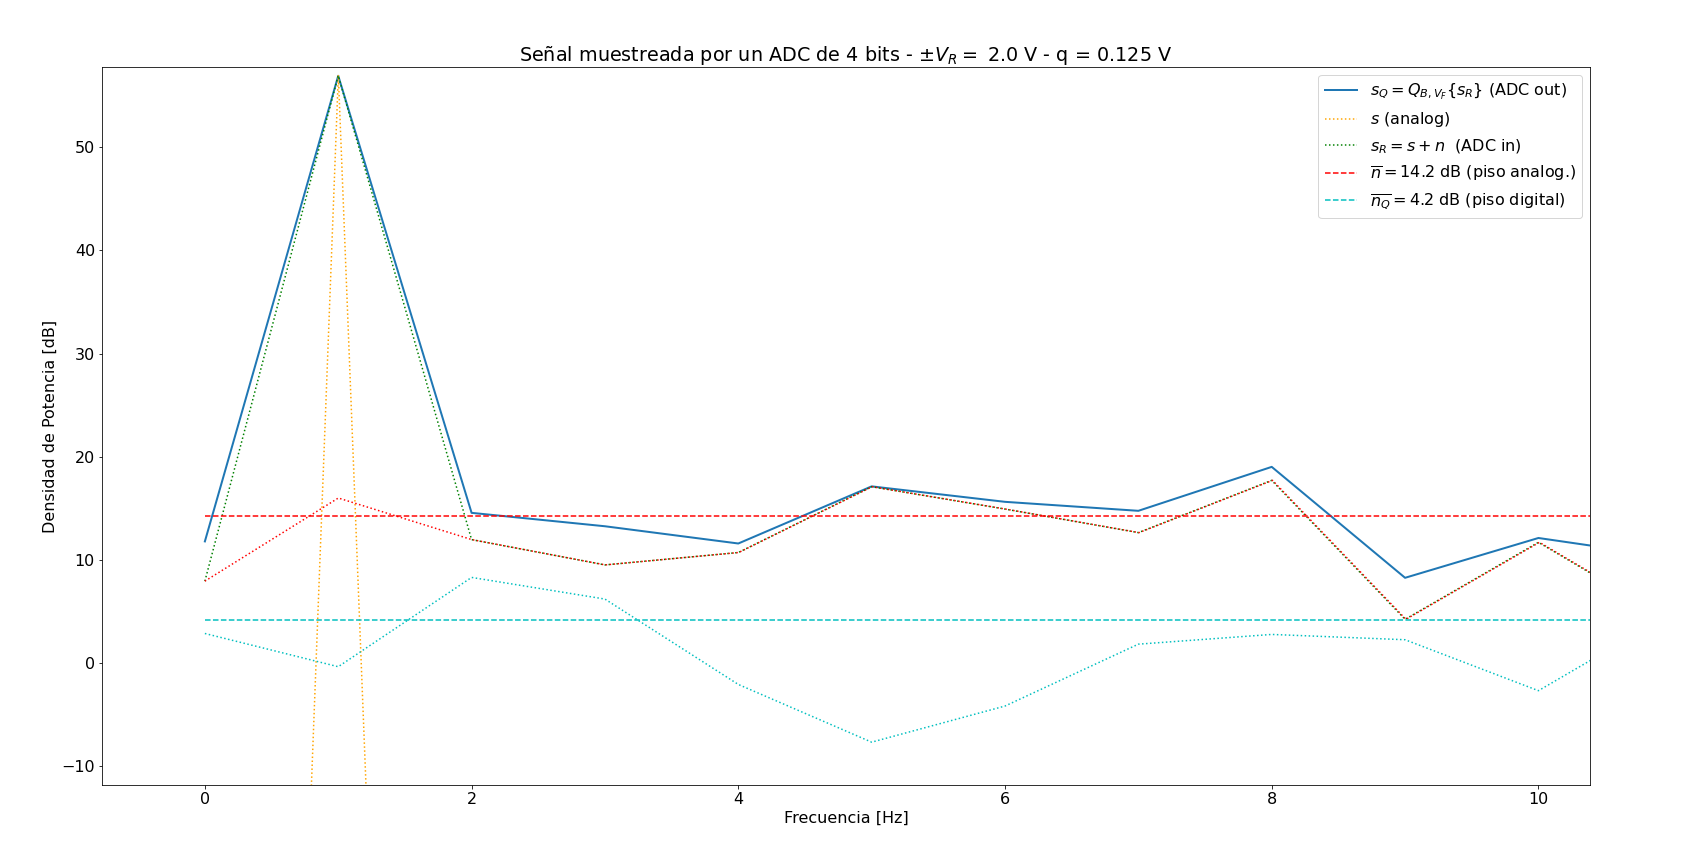

Podemos ver que el señal verde, sr, que es el señal ruidoso no quantizado, a partir de una cierta frecuencia, està cuasi igual al ruido, porque el señal senoidal solo tiene una frequencia por definicion.  
Lo mas interesante aqui es observar que para k=10, el ruido de quantizacion es debajo del ruido analogo. Este ruido de quantizacion se agrega al ruido analogo. El señal quantizado (azul) es la suma del señal señoidal, del ruido analogo, y del ruido de quantizacion.  
Si ponemos k = 1, poniendo la potencia del ruido analogo al igual de la potencia del ruido de quantizacion, la medias estan iguales.  
Y si pinemos k = 1/10, poniendo la potencia del ruido analogo 10 vez menor que la potencia del ruido de quantizacion, la medias estan iguales.

Quando k aumenta, el ruido analogico aumenta mucho, y el ruido de cuantizacion disminuye un poquito.

Text(0.5, 1.0, 'Ruido de cuantización para 4 bits - $\\pm V_R= $ 2.0 V - q = 0.125 V para k = 10')

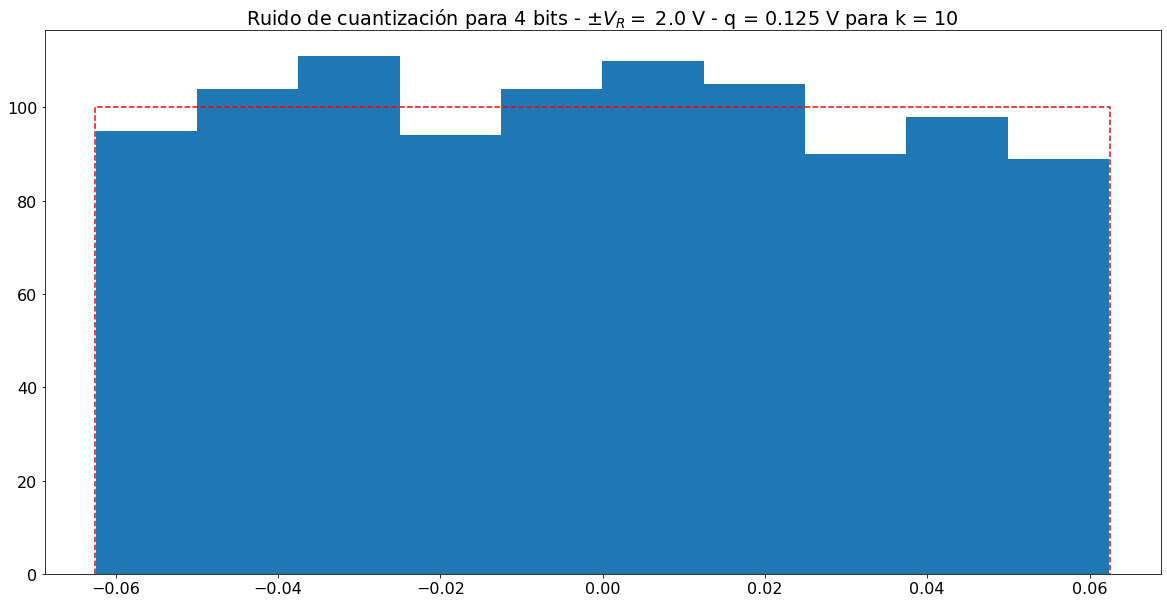

In [74]:
plt.figure(3)
bins = 10
plt.hist(nq10, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V para k = 10'.format(B, Vf, q))

Text(0.5, 1.0, 'Ruido de cuantización para 4 bits - $\\pm V_R= $ 2.0 V - q = 0.125 V para k = 1')

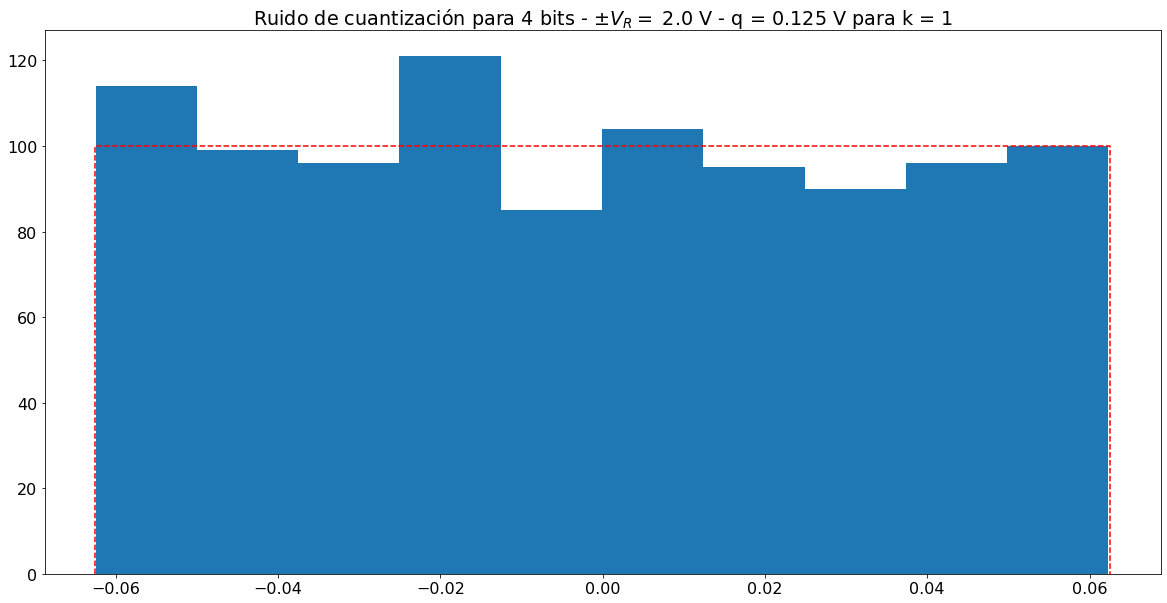

In [75]:
plt.figure(3)
bins = 10
plt.hist(nq1, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V para k = 1'.format(B, Vf, q))

Text(0.5, 1.0, 'Ruido de cuantización para 4 bits - $\\pm V_R= $ 2.0 V - q = 0.125 V para k = 1/10')

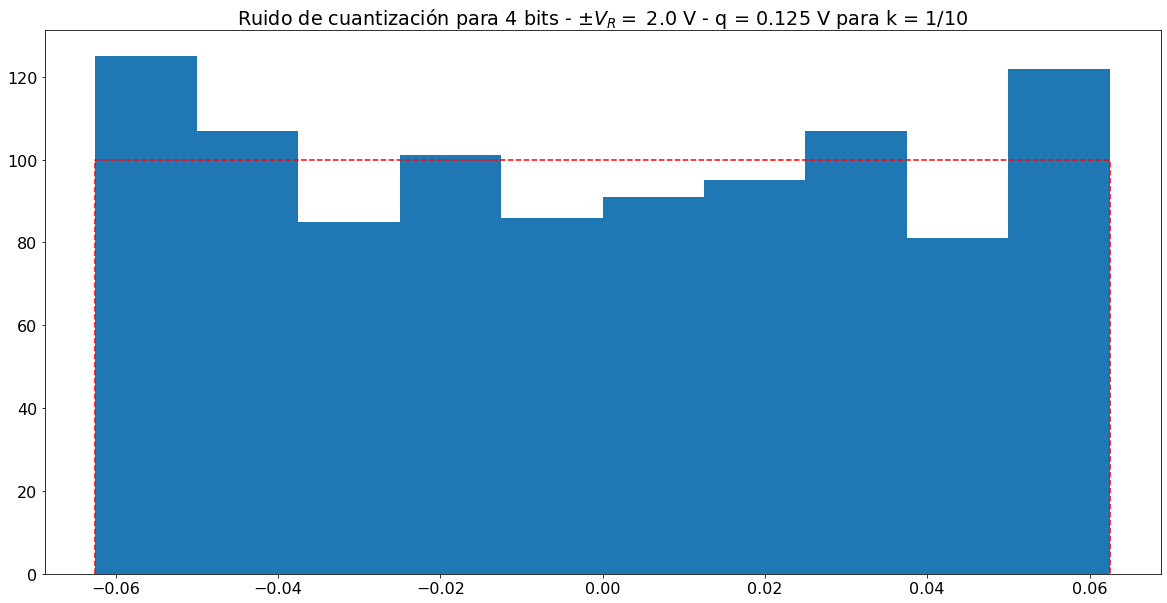

In [76]:
plt.figure(3)
bins = 10
plt.hist(nq01, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V para k = 1/10'.format(B, Vf, q))

Este grafica nos muestra que el ruido de cuantizacion no sigue una distribucion normal como el ruido analogo, pero una distribucion uniforme.